#### MAIN: In a Binomial model of a single stock with non-zero interest rate, assume that we can hedge any fraction of a stock, use policy gradient to train the optimal policy of hedging an ATM American put option with maturity T = 10. WHEN do you early exercise the option? Is your solution same as what you obtain from delta hedging?

#### OPTIONAL: For really advanced students: supppose the stock follows a GBM (Geometric Brownian Motion), construct an algorithm to train a Neural Network that hedges an ATM American Put Option

#### OPTIONAL BONUS: After solving the optional question, sue the Soft Actor Critic algorithm in TF agent to solve the problem again in the colab.resarch.google.com environment. Compare your results

#### ADVANCED EXTRA BONUS: Implement the GAC algorithm using the TF agent library and solve the optinal problem

#### Imports

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.distributions import MultivariateNormal, Normal
import numpy as np
from tqdm import tqdm
from scipy.special import comb
import math
import matplotlib.pyplot as plt
import random
from collections import deque

/Users/clemmie/opt/anaconda3/envs/Python3_7_Plus_R/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 10 Step American Put Option

In [2]:
#https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b 
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_dim,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,1)
        self.tanh = nn.Tanh()
            
    def forward(self, state):
        action = self.tanh(self.linear1(state))
        action = self.tanh(self.linear2(action))
        action = self.linear3(action)
        return action    

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_dim + action_dim,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,1)
        self.relu = nn.ReLU()
            
    def forward(self, state, action):
        input_tensor = torch.cat([state,action],1)
        value = self.relu(self.linear1(input_tensor))
        value = self.relu(self.linear2(value))
        value = self.linear3(value)
        return value

class ReplayBuffer():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, np.array([done]))
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        
        batch = random.sample(self.buffer, batch_size)
        
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
            
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
     
    def __len__(self):
        return len(self.buffer)

class DDPGAgent():
    def __init__(self, state_dim, action_dim, 
                 actor_lr=1e-4, critic_lr=1e-3, 
                 gamma=0.99, tau=1e-2, max_memory=50000):
        
        self.state_dim=state_dim
        self.action_dim=action_dim
        self.gamma=gamma
        self.tau=tau
        
        ###Actors and Critics
        self.actor = Actor(self.state_dim)
        self.target_actor = Actor(self.state_dim)
        self.critic = Critic(self.state_dim,self.action_dim)
        self.target_critic = Critic(self.state_dim,self.action_dim)
        
        #Make sure the params are the same for both networks. from actor -> target_actor, critic -> target_critic
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        #For training:
        self.replay_buffer = ReplayBuffer(max_memory)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def get_action(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        state.requires_grad=True
        action = self.actor.forward(state)
        action = action.detach().numpy()[0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, done = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        done = torch.FloatTensor(done)
        ##Critic Update
        # print(f'State: {states},Action: {actions}')
        Q_values = self.critic.forward(states, actions.detach())
        next_actions = self.target_actor.forward(next_states)
        next_Q = self.target_critic.forward(next_states, next_actions.detach())
        Q_targets = rewards + (1 - done) * self.gamma * next_Q
        critic_loss = self.critic_criterion(Q_values,Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        ####Policy Update
        actor_loss = -self.critic.forward(states,self.actor.forward(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        ####Update Target Networks
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)
    
class AmericanOptionHedgingEnvironment():
    def __init__(self, strike_price,init_stock_price,up_factor,down_factor,risk_free_rate,termination_time):
        self.strike_price=strike_price
        self.init_stock_price=init_stock_price
        self.up_factor=up_factor
        self.down_factor=down_factor
        self.risk_free_rate=risk_free_rate
        self.hedge_portfolio_value=0
        self.time_step = 0
        self.termination_time=termination_time
        self.risk_neutral_probability = (1 + risk_free_rate - down_factor) / (up_factor - down_factor)
    
    def is_terminal(self):
        if self.time_step == self.termination_time:
            return 1
        else:
            return 0
            
    def reward_function(self,up_price,down_price,action,state):
        up_payoff = max(self.strike_price - up_price,0)
        down_payoff = max(self.strike_price - down_price,0)
        up_hedge = action * (up_price - state) - up_payoff
        down_hedge = action * (down_price - state) - down_payoff
        return -abs(up_hedge - down_hedge)
    
    def reset(self):
        self.time_step = 0
        init_state = np.array([self.init_stock_price,self.strike_price])
        return init_state
    
    def step(self,state,action):
        self.time_step += 1
        up_price = self.up_factor * state[0].item()
        down_price = self.down_factor * state[0].item()
        next_price = np.random.choice([up_price, down_price],
                                     p=[self.risk_neutral_probability,1-self.risk_neutral_probability])
        next_state=np.array([next_price,self.strike_price])
        reward = self.reward_function(up_price,down_price,action.item(),state[0].item())
        return next_state, reward

In [3]:
state_dim=2
action_dim=1
strike_price=62.0
init_stock_price=60.0
up_factor=1.1
down_factor=0.95
risk_free_rate=0.03
termination_time=10
episodes=5000
batch_size=64
#https://arxiv.org/pdf/1911.11679.pdf - becareful of actor_learning_rate vs critic_learning_rate
env = AmericanOptionHedgingEnvironment(strike_price,init_stock_price,up_factor,down_factor,risk_free_rate,termination_time)
ddpg_agent = DDPGAgent(state_dim,action_dim,
                       actor_lr=4e-5,critic_lr=2e-4)

rewards = []
for e in range(episodes+1):
    state = env.reset()
    episode_reward = 0
    for t in range(termination_time):
        action = ddpg_agent.get_action(state)
        noise = np.random.normal(0,1, size=action_dim) / (1 + e/100) #Progressively reduce noise as we learn
        action = action + noise 
        next_state, reward = env.step(state,action)
        ddpg_agent.replay_buffer.push(state,action,reward,next_state,env.is_terminal())
        if len(ddpg_agent.replay_buffer) > batch_size:
            ddpg_agent.update(batch_size)
        
        state = next_state
        episode_reward += reward
    
    rewards.append(episode_reward)
    if e % 500 == 0:
        print(f'Episode:{e}, State: {state}, Action: {action}, Reward: {reward}')

Episode:0, State: [74.77091626 62.        ], Action: [-0.47544874], Reward: -5.613116468966651


/Users/clemmie/opt/anaconda3/envs/Python3_7_Plus_R/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136152924/work/torch/csrc/utils/tensor_new.cpp:204.)


Episode:500, State: [116.07533406  62.        ], Action: [0.07517658], Reward: -1.1899290637598416
Episode:1000, State: [48.16432331 62.        ], Action: [-0.96587489], Reward: -0.2595178153026332
Episode:1500, State: [116.07533406  62.        ], Action: [-0.24437949], Reward: -4.478910164262164
Episode:2000, State: [64.57488222 62.        ], Action: [-0.62501023], Reward: -0.7271523099800774
Episode:2500, State: [55.76921647 62.        ], Action: [-0.65741473], Reward: -0.44180915120404407
Episode:3000, State: [134.40301839  62.        ], Action: [-0.05131891], Reward: -0.9405567449704332
Episode:3500, State: [86.57685041 62.        ], Action: [-0.05502739], Reward: -0.6496497543348329
Episode:4000, State: [100.24687942  62.        ], Action: [-0.02479312], Reward: -0.33892265673597544
Episode:4500, State: [74.77091626 62.        ], Action: [-0.03590803], Reward: -0.3661195076146288
Episode:5000, State: [74.77091626 62.        ], Action: [0.02849622], Reward: -0.336424445191722


Text(0.5, 1.0, 'Negative Total Reward vs Episodes')

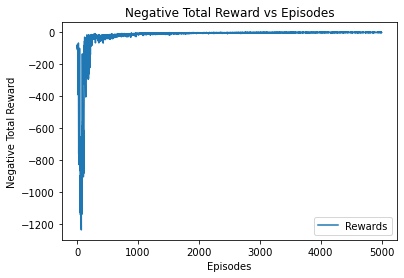

In [4]:
x_axis = np.arange(1,len(rewards)+1)
plt.plot(x_axis,rewards, label='Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Negative Total Reward')
plt.title('Negative Total Reward vs Episodes')

#### TRIAL RUN

In [16]:
state = env.reset()
episode_reward = 0
for t in range(termination_time):
    action = ddpg_agent.get_action(state)
    action = action
    next_state, reward = env.step(state,action)
    print(f'State: {state}, Action: {action}, Reward: {reward}')
    state = next_state

State: [60. 62.], Action: [-0.5611225], Reward: -0.050102293491363525
State: [57. 62.], Action: [-0.9162303], Reward: -0.016230756044385508
State: [62.7 62. ], Action: [-0.25509408], Reward: -0.03584016665816159
State: [68.97 62.  ], Action: [0.00356483], Reward: -0.03687991921976214
State: [65.5215 62.    ], Action: [-0.0083449], Reward: -0.08201551684308811
State: [72.07365 62.     ], Action: [0.00414082], Reward: -0.044766565264184086
State: [79.281015 62.      ], Action: [0.00068752], Reward: -0.008176059523025534
State: [87.2091165 62.       ], Action: [0.01162189], Reward: -0.1520301484588976
State: [82.84866068 62.        ], Action: [0.00476126], Reward: -0.05916955585895714
State: [91.13352674 62.        ], Action: [0.00393181], Reward: -0.05374799698482316


### American Early Excercise

For American Put Option, your reward for excercising or not depends on 
the current payoff vs expected value of the next step

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_dim,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,1)
        self.tanh = nn.Tanh()
            
    def forward(self, state):
        action = self.tanh(self.linear1(state))
        action = self.tanh(self.linear2(action))
        action = self.linear3(action)
        action = self.tanh(action)
        return action    
    
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_dim + action_dim,256)
        self.linear2 = nn.Linear(256,256)
        self.linear3 = nn.Linear(256,1)
        self.relu = nn.ReLU()
            
    def forward(self, state, action):
        input_tensor = torch.cat([state,action],1)
        value = self.relu(self.linear1(input_tensor))
        value = self.relu(self.linear2(value))
        value = self.linear3(value)
        return value
    
class ReplayBuffer():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, np.array([done]))
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        
        batch = random.sample(self.buffer, batch_size)
        
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
            
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
     
    def __len__(self):
        return len(self.buffer)
    
class DDPGAgent():
    def __init__(self, state_dim, action_dim, 
                 actor_lr=1e-5, critic_lr=1e-4, 
                 gamma=0.99, tau=1e-2, max_memory=50000):
        
        self.state_dim=state_dim
        self.action_dim=action_dim
        self.gamma=gamma
        self.tau=tau
        
        ###Actors and Critics
        self.actor = Actor(self.state_dim)
        self.target_actor = Actor(self.state_dim)
        self.critic = Critic(self.state_dim,self.action_dim)
        self.target_critic = Critic(self.state_dim,self.action_dim)
        
        #Make sure the params are the same for both networks. from actor -> target_actor, critic -> target_critic
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        #For training:
        self.replay_buffer = ReplayBuffer(max_memory)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def get_action(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        state.requires_grad=True
        action = self.actor.forward(state)
        action = action.detach().numpy()[0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, done = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        done = torch.FloatTensor(done)
        ##Critic Update
        # print(f'State: {states},Action: {actions}')
        Q_values = self.critic.forward(states, actions.detach())
        next_actions = self.target_actor.forward(next_states)
        next_Q = self.target_critic.forward(next_states, next_actions.detach())
        Q_targets = rewards + (1 - done) * self.gamma * next_Q
        critic_loss = self.critic_criterion(Q_values,Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        ####Policy Update
        actor_loss = -self.critic.forward(states,self.actor.forward(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        ####Update Target Networks
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)
            
class AmericanOptionExerciseEnvironment():
    def __init__(self, strike_price,init_stock_price,up_factor,down_factor,risk_free_rate,termination_time):
        self.strike_price=strike_price
        self.init_stock_price=init_stock_price
        self.up_factor=up_factor
        self.down_factor=down_factor
        self.risk_free_rate=risk_free_rate
        self.hedge_portfolio_value=0
        self.time_step = 0
        self.termination_time=termination_time
        self.risk_neutral_probability = (1 + risk_free_rate - down_factor) / (up_factor - down_factor)
        
    def reward_function(self,up_price,down_price,exercise,state):
        up_payoff = max(strike_price - up_price,0)
        down_payoff = max(strike_price - down_price,0)
        current_payoff = max(strike_price - state,0)
        value = self.risk_neutral_probability * up_payoff + (1-self.risk_neutral_probability) * down_payoff
        expected_value = value / (1 + risk_free_rate)
        if self.time_step == self.termination_time or bool(exercise):
            return current_payoff
        else:
            return expected_value - current_payoff
    
    def reset(self):
        self.time_step = 0
        init_state = np.array([self.init_stock_price,self.strike_price])
        return init_state
    
    def step(self,state,action):
        self.time_step += 1
        exercise = action.item() >= 0.0
        up_price = self.up_factor * state[0].item()
        down_price = self.down_factor * state[0].item()
        next_price = np.random.choice([up_price, down_price],
                                     p=[self.risk_neutral_probability,1-self.risk_neutral_probability])
        next_state=np.array([next_price,self.strike_price])
        reward = self.reward_function(up_price,down_price,exercise,state[0].item())
        # print(f'State: {state}, Reward: {reward}, Action: {action}')
        return next_state, reward, float(exercise)

In [7]:
state_dim=2
action_dim=1
strike_price=62.0
init_stock_price=60.0
up_factor=1.1
down_factor=0.90
risk_free_rate=0.03
termination_time=10
episodes=10000
batch_size=64

exercise_env = AmericanOptionExerciseEnvironment(strike_price,init_stock_price,up_factor,down_factor,
                                         risk_free_rate,termination_time)
ddpg_exercise_agent = DDPGAgent(state_dim,action_dim,
                       actor_lr=5e-6,critic_lr=2e-4)

rewards = []
for e in range(episodes+1):
    state = exercise_env.reset()
    episode_reward = 0
    for t in range(termination_time):
        action = ddpg_exercise_agent.get_action(state)
        noise = np.random.normal(0,1, size=action_dim)
        action = action + (np.tanh(noise * 10)) 
        next_state, reward, done = exercise_env.step(state,action)
        ddpg_exercise_agent.replay_buffer.push(state,action,reward,next_state,done)
        if len(ddpg_exercise_agent.replay_buffer) > batch_size:
            ddpg_exercise_agent.update(batch_size)
        
        state = next_state
        episode_reward += reward
        
        if done:
            break
        
    rewards.append(episode_reward)
    if e % 500 == 0:
        print(f'Episode:{e}, State: {state}, Action: {action}, Reward: {reward}')

Episode:0, State: [65.34 62.  ], Action: [0.54052216], Reward: 2.5999999999999943
Episode:500, State: [48.6 62. ], Action: [1.9706921], Reward: 8.0
Episode:1000, State: [64.039734 62.      ], Action: [0.05499083], Reward: 0
Episode:1500, State: [59.4 62. ], Action: [1.89132534], Reward: 8.0
Episode:2000, State: [66. 62.], Action: [0.00898558], Reward: 2.0
Episode:2500, State: [72.6 62. ], Action: [0.00079272], Reward: 0
Episode:3000, State: [64.6866 62.    ], Action: [0.00026655], Reward: 0
Episode:3500, State: [79.0614 62.    ], Action: [0.00014362], Reward: 0
Episode:4000, State: [59.4 62. ], Action: [1.99844399], Reward: 8.0
Episode:4500, State: [54. 62.], Action: [0.00016817], Reward: 2.0
Episode:5000, State: [54. 62.], Action: [7.82012939e-05], Reward: 2.0
Episode:5500, State: [52.9254 62.    ], Action: [0.00019413], Reward: 3.1939999999999955
Episode:6000, State: [59.4 62. ], Action: [1.99992704], Reward: 8.0
Episode:6500, State: [87.846 62.   ], Action: [5.36441517e-07], Reward:

In [13]:
state = exercise_env.reset()
episode_reward = 0
for t in range(10):
    action = ddpg_exercise_agent.get_action(state)
    action = action
    next_state, reward, done = exercise_env.step(state,action)
    print(f'State: {state}, Action: {action}, Reward: {reward}')
    state = next_state
    
    if done:
        break

State: [60. 62.], Action: [-1.], Reward: 0.718446601941749
State: [54. 62.], Action: [0.99999994], Reward: 8.0


### Analytical Answer for Optimal Exercise

In [14]:
'''Calculate for a given set of params, which prices should you exercise at'''
def find_optimal_exercise(price_pairs, p, strike_price):
    exercise_prices = []
    prev_price_pairs = []
    state_price_value = {}
    for pair in price_pairs:
        up_payoff = pair[0][0][1]
        down_payoff = pair[0][1][1]
        value = p * up_payoff + (1-p) * down_payoff
        value = value / (1+risk_free_rate)
        prev_price = pair[0][0][0]/up_factor
        prev_price_pairs.append((prev_price,value))
        state_price_value[prev_price] = value
        if max(strike_price - prev_price, 0) > value:
            # print(f'Price: {prev_price}, Payoff: {max(strike_price - prev_price, 0)}, Value: {value}')
            exercise_prices.append(prev_price)

    return np.lib.stride_tricks.sliding_window_view(np.array(prev_price_pairs), window_shape = (2,2), axis=(0,1)), \
           exercise_prices, state_price_value

def binomial_american_optimal_exercise(current_price, strike_price, risk_free_rate, termination_time, up_factor, down_factor):
    #Risk-neutral probability - p
    exercise_prices = []
    all_prices = []
    all_price_values = {}
    p = ((1+risk_free_rate) - down_factor)/(up_factor - down_factor)
    final_prices = []
    for t in range(termination_time+1):
        price = current_price * (up_factor ** (termination_time-t)) * (down_factor ** (t))
        payoff = max(strike_price - price, 0)
        final_prices.append((price,payoff))
    prices = np.lib.stride_tricks.sliding_window_view(np.array(final_prices), window_shape = (2,2), axis=(0,1))
    
    while len(prices) != 1:
        prices, exe_prices, price_vals = find_optimal_exercise(prices,p,strike_price)
        exercise_prices.extend(exe_prices)
        all_price_values = {**all_price_values,**price_vals}
        all_prices.extend(prices)
    
    return all_prices, exercise_prices, all_price_values

all_prices, optimal_exercise_prices, all_price_values = \
    binomial_american_optimal_exercise(init_stock_price,strike_price,
                                       risk_free_rate,termination_time,up_factor,down_factor)

In [15]:
### FOR ALL STATES - find out which states my policy exercises and compare it with the analytical answer
all_prices_flatten = np.unique(np.array([x[0,:,0] for x in all_prices]).flatten())
all_states = [ np.array([x , strike_price]) for x in all_prices_flatten]
actions = [ ddpg_exercise_agent.get_action(s) for s in all_states ]
optimal_exercise_prices = np.array(optimal_exercise_prices)

#Find the common ones with the optimal list
correnct_optimal_exercise_prices = []
missed_optimal_exercise_prices = []
for s, a in zip(all_states, actions):
    if a[0] > 0:
        if np.isin(s[0],optimal_exercise_prices):
            correnct_optimal_exercise_prices.append(s[0])
        else:
            print(f'Wrongly Exercising: {s[0]}')
    else:
        if np.isin(s[0],optimal_exercise_prices):
            payoff = max(strike_price - s[0], 0)
            val = all_price_values[s[0]]
            missed_optimal_exercise_prices.append((s[0],a[0],payoff,val))


print(f'Missed Optimal Exercise Prices')
for price, action, payoff, val in missed_optimal_exercise_prices:
    print(f'Price: {price}, Action: {action}, Payoff: {payoff}, Expected Value: {val}')


Missed Optimal Exercise Prices
Price: 57.63576060000001, Action: -0.9999985098838806, Payoff: 4.364239399999988, Expected Value: 3.8873251882316806
Price: 58.21794000000003, Action: -0.9999998807907104, Payoff: 3.782059999999973, Expected Value: 3.1973814241966325
Price: 58.80600000000002, Action: -1.0, Payoff: 3.1939999999999813, Expected Value: 2.649846063555103
Price: 59.40000000000001, Action: -1.0, Payoff: 2.599999999999987, Expected Value: 2.204167528800343
